In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#modules to find path of all sessions
import glob
import os
import numpy as np
import pickle
import platform
import math
from IPython.display import clear_output, display, HTML
from matplotlib.patches import Rectangle
from matplotlib import collections  as mc
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter as smooth
import matplotlib
from __future__ import print_function
np.set_printoptions(precision=3, suppress=True)
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings('ignore')

### you might need to change the line below if you want to regenerate the figure on a differente computer 
### Below we will run some preprocessing notebooks. In our case, our preprocessing notebooks are located in 
### a folder ("load_preprocess_mouse") which is at the same level that the folder that contain the notebooks 
### that generate the figures (for instance this one)


notebookPath=os.path.dirname(os.path.realpath("__file__"))
pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_mouse")
os.chdir(pathToProcessingNotebooks)   
%run loadMouse_documentation.ipynb
%run loadRawSpike_documentation.ipynb
%run plotMouse_Behavior.ipynb


#######

def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False

def cm2inch(value):
    return value/2.54
    

#Those parameters are overwritten if there is a .behav_param file
paramCarola={
    "distanceToRun":100,
    "maxTrialDuration": 60,
    "valveONTime":50,
    "minInterTrialDuration":15,
    "immobilityDuration":2,
    #to read .eeg (put None to not read .eeg)
    "nChannelElectro":32, #32
    "channel_opto": -6, #not used
    "channel_lickBreak":-5,
    "channel_reward": -4, #not used currently
    "channel_sound": -3, #not used
    "channel_trialON": -2,
    "channel_beamBreak": -1,
}    


#### root is the path to the folder where the data (MOUXXX, MOUXXY, ....ALLMOU_Analysis) are located
### you might need to change the line below depending on your computer orgnization

if platform.system()=='Linux':
    root="/data"
else:
    root="/Users/davidrobbe/Documents/Data/"
    
    
# Where to Save Files
saveFigurePath=os.path.join(root,"ALLMOU_Analysis","FigForMS")

    
print("path to data is %s"%root)
print("")
print("importing done")

path to data is /data

importing done


ERROR: File `'/home/david/Dropbox/iPythonNotebooks/load_preprocess_mouse/plotMouse_SpikingActvity.ipynb.py'` not found.


In [2]:
%run plotMouse_SpikingActivity.ipynb

In [3]:
def plot_distribution(rawdata,maxminstep,xyLabels=["Bins",'NEvents'],ax=None,histType='bar'):   
    
    if ax is None:
        ax = plt.gca()
        
        
    ax.hist(rawdata,np.arange(maxminstep[0],maxminstep[1]+maxminstep[2],maxminstep[2]),color='k',histtype=histType,linewidth=1)
    #ax.set_xlim(maxminstep[:2])
    ax.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    ax.set_xlabel(xyLabels[0],fontsize=12)
    ax.set_ylabel(xyLabels[1],fontsize=12)
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')
    
    return ax

# <span style="color:red">New Part of the Code !</span> 
## New analysis for reviewer 2.
## Test the impact of the variability of run durations on firing rate mofulation (peak around start and end)

### The code below is going to loop accross recording session and return the beg and end times of detected run periods. This allows to look at the distribution of run durations. 

In [4]:
behaviorType=["Runs","all"]
tagList = ["GoodPerfo"]
#specfiy run max 
minDuration=2
maxDuration=15

#list of all animals in data base:
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]

runsDurationsAccrossSessions=[]
runsDurationsInSessions=[]
allSessionsAnalyzed=[]
#loop through aniaml animal
for animal in animalList:

    #Get the list of all sessions in one animal
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)   

    #loop through sessions and check for presence of tag to analyse or not
    for index,session in enumerate(sessionList):
        #if tag list is not emtpy
        if tagList:
            #check if the session has the specficied tag
            if not has_tag(root, animal, session, tagList):
                continue
        # get session data   
        data=Data(root,session[:6],session,paramCarola,redoPreprocess=False)
        clear_output()
        allSessionsAnalyzed.append(session)
        runBegs,runEnds= np.asarray(detect_running_period(data, minDuration, maxDuration, runType='all')[0:2])
        runDurations=[]
        for runBeg,runEnd in zip(runBegs,runEnds):
            runDurations.extend([runEnd-runBeg])
        runsDurationsInSessions.append(runDurations)
        runsDurationsAccrossSessions.extend(runDurations)
      

In [5]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
maxminstep=[2,15,1]
binCenters=np. arange(maxminstep[0]+maxminstep[2]/2,maxminstep[1]+maxminstep[2]/2,maxminstep[2])
for runsDurationsInSession in runsDurationsInSessions:
    Nevent,Binedges=np.histogram(runsDurationsInSession,np.arange(maxminstep[0],maxminstep[1]+maxminstep[2],maxminstep[2]),density=False)
    ax1.plot(binCenters,Nevent)

ax1.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
ax1.set_xlabel("run duration",fontsize=12)
ax1.set_ylabel("Nber of runs",fontsize=12)
ax1.spines['top'].set_color("none")
ax1.spines['right'].set_color("none")
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.get_xaxis().set_tick_params(direction='out')

plot_distribution(runsDurationsAccrossSessions,[2,15,1],xyLabels=["run duration(s)","Nber of runs"],histType='bar',ax=ax2)

## The code below is going to loop accross recording sessions
#### 1) get the distribution of the run duration (min =2, max=15) an select a subsamples of run durations based on percentile range
#### 2) recompute the firing rate modulation significance during these runs

In [6]:
## cdefine percentile range

#RunDurationsPercentilesLimits=[0,100]
#RunDurationsPercentilesLimits=[25,75]
RunDurationsPercentilesLimits=[50-25/2,50+25/2]
RunDurationsPercentilesLimits

[37.5, 62.5]

## Part I: For all the cells accross good sessions compute meanfiringrate during runs and find significant modulation portion
## <span style="color:red">Take ~ 10 min to run!</span> No need to rerun it each time: output are saved in pickle files
### below is the case in which a wide range of run duration (from 2 to 15s) is considered)

In [36]:
behaviorType=["Runs","all"]
tagList = ["GoodPerfo"]
#specfiy run max 

#list of all animals in data base:
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]


#loop through aniaml animal
for animal in animalList:

    #Get the list of all sessions in one animal
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)   

    #loop through sessions and check for presence of tag to analyse or not
    for index,session in enumerate(sessionList):
        #if tag list is not emtpy
        if tagList:
            #check if the session has the specficied tag
            if not has_tag(root, animal, session, tagList):
                continue
        # get session data   
        sessionData=Data(root,session[:6],session,paramCarola,redoPreprocess=False)
        #clear_output()
        minDuration=2
        maxDuration=15
        
        if set(RunDurationsPercentilesLimits)==set([0,100]):
            minDuration=2
            maxDuration=15
            
        else:
            runBegs,runEnds= np.asarray(detect_running_period(sessionData, minDuration, maxDuration, runType='all')[0:2])
            runDurations=[]
            for runBeg,runEnd in zip(runBegs,runEnds):
                runDurations.extend([runEnd-runBeg])
        
            minDuration=round(float(np.percentile(runDurations,[RunDurationsPercentilesLimits[0]])),2)
            maxDuration=round(float(np.percentile(runDurations,[RunDurationsPercentilesLimits[1]])),2)
        
        print("Session %s is beeing analyzed with  GetAllSignificantModulation function"%session)
        print([minDuration,maxDuration])
        GetAllSignificantModulation(sessionData,redo=True,saveAsPickle=True,excludeDrift=True,behaviorType=["Runs","all"],minDuration=minDuration,maxDuration=maxDuration)
        
        
        
      

Preprocess behavior data loaded from /Users/davidrobbe/Documents/Data/MOU025/Experiments/MOU025_2014_08_22_15_48/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /Users/davidrobbe/Documents/Data/MOU025/Experiments/MOU025_2014_08_22_15_48/Analysis/rawspikedata.p
Session MOU025_2014_08_22_15_48 is beeing analyzed with  GetAllSignificantModulation function
[5.82, 9.03]
Shank 1  Cluster 2
Shank 2  Cluster 2
Shank 2  Cluster 3
Shank 2  Cluster 4
Shank 3  Cluster 2
Shank 3  Cluster 3
Shank 4  Cluster 2
Shank 4  Cluster 3
Saved pickle: /Users/davidrobbe/Documents/Data/MOU025/Experiments/MOU025_2014_08_22_15_48/Analysis/ModulationDuringallRunsRunMinMax_5.82-9.03.p
Preprocess behavior data loaded from /Users/davidrobbe/Documents/Data/MOU025/Experiments/MOU025_2014_08_29_12_54/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /Users/davidrobbe/Documents/Data/MOU025/Experiments/MOU025_2014_08_29_12_54/Analysis/rawspikedata.p
Session MOU025_2014_08_29_12_54 is beeing

## Part II: Calculate the mean duration of the run epochs for all the units accross sessions to normalize run duration accross session
### for subset of run with homogeneous length


In [7]:
behaviorType=["Runs","all"]
tagList = ["GoodPerfo"]
targetStrings=["positive","negative"]
#list of all animals
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]
totalneurons=0
totalposmod=0
totalnegmod=0


### loop throught the session to find the length of average firing rate for the different sessions


averageRunDurationAccrossAllUnits=[]



#loop on animal
for animal in animalList:

    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)   

    #loop through sessions and load pickle file
    for index,session in enumerate(sessionList):


        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                           
        
        
        sessionData=Data(root,session[:6],session,paramCarola,redoPreprocess=False)
        #clear_output()
        minDuration=2
        maxDuration=15
        
        if set(RunDurationsPercentilesLimits)==set([0,100]):
            minDuration=2
            maxDuration=15
            
        else:
            runBegs,runEnds= np.asarray(detect_running_period(sessionData, minDuration, maxDuration, runType='all')[0:2])
            runDurations=[]
            for runBeg,runEnd in zip(runBegs,runEnds):
                runDurations.extend([runEnd-runBeg])
        
            minDuration=round(float(np.percentile(runDurations,[RunDurationsPercentilesLimits[0]])),2)
            maxDuration=round(float(np.percentile(runDurations,[RunDurationsPercentilesLimits[1]])),2)
        
        
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        
        if (minDuration==2) & (maxDuration==15):
            picklePath=os.path.join(sessionData.analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") +  behaviorType[0] + ".p")
        else:        
            picklePath=os.path.join(sessionData.analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") +  behaviorType[0] + 'RunMinMax_' + str(minDuration) + '-' + str(maxDuration) + ".p")

        
        firingRatesModulation=pickle.load(open(picklePath,"rb"))
        
        
        for shank in firingRatesModulation["MeanFiringRateZscored"]:
            for cluster in firingRatesModulation["MeanFiringRateZscored"][shank]:
                totalneurons+=1
                if firingRatesModulation["BiggestModulationSign"][shank][cluster] in targetStrings:
                    averageRunDurationAccrossAllUnits.append(len(firingRatesModulation["insideBehaviorIndexes"][shank][cluster]))
                    if firingRatesModulation["BiggestModulationSign"][shank][cluster]=="positive":
                        totalposmod+=1
                    else:
                        totalnegmod+=1
                
clear_output()                
nSideBin=firingRatesModulation["insideBehaviorIndexes"][shank][cluster][0]
medianAverageRunDurationAccrossAllUnits=np.median(averageRunDurationAccrossAllUnits)
print("median duration of runs %s" %medianAverageRunDurationAccrossAllUnits)
print("total number of unit analyzed: %i" %totalneurons)
print("number of modulated units %s" %(len(averageRunDurationAccrossAllUnits)))
print("percent positvely modulated: %i" %(totalposmod/totalneurons*100))
print("percent negatively modulated: %i" %(totalnegmod/totalneurons*100))


median duration of runs 28.0
total number of unit analyzed: 167
number of modulated units 122
percent positvely modulated: 62
percent negatively modulated: 10


## Part III:  ReNormalize Firing rate in the time domain (versus median run duration of all units)

### Can select units that have been determined to have a postive or negative modulation during run using the function GetModulatedPortionsDuringRun
(This code is Modified from an orginal version below.june 2016)

In [8]:
def normalizeFiringRateInTime(thisFiringRateModulation,insideRunBins,medianAverageRunDurationAccrossAllUnits,signifiantModulationIndexes):
    
    meanFiringRateInRun=thisFiringRateModulation[insideRunBins]
    runIndexes=range(len(meanFiringRateInRun))
    runIndexesInterp=np.arange(0,float(runIndexes[-1])+float(runIndexes[-1])/float(medianAverageRunDurationAccrossAllUnits-1),float(runIndexes[-1])/float(medianAverageRunDurationAccrossAllUnits-1))
    if len(runIndexesInterp)>medianAverageRunDurationAccrossAllUnits:
        runIndexesInterp=np.asarray([x for x in runIndexesInterp if x <= float(runIndexes[-1])])

    # do the itnerpolation
    meanFiringRateInRunNorm=np.interp(runIndexesInterp,runIndexes,meanFiringRateInRun)
    # reconcatenate the borders
    normFiringRateInRun=np.concatenate([thisFiringRateModulation[0:insideRunBins[0]],meanFiringRateInRunNorm,thisFiringRateModulation[insideRunBins[-1]+1:]],axis=0)

    
    # find the significant modulation on time normalized data
    allIndexes=list(range(len(thisFiringRateModulation)));
    allIndexesInterpt=np.concatenate([allIndexes[:insideRunBins[0]],runIndexesInterp+insideRunBins[0],allIndexes[-insideRunBins[0]:]],axis=0)
    
    #Get the border of the modulation
    borders=contiguous_regions(np.asarray([X in signifiantModulationIndexes for X in allIndexes])).tolist()
    interpolatedSignificantIndexes=[]
    for startstop in borders:
        interpolatedSignificantIndexes.append([index for index,value in enumerate(allIndexesInterpt) if (value>=startstop[0] and value<=startstop[1])])
    
    return normFiringRateInRun,interpolatedSignificantIndexes
    
    
    
    

# loop across data to normalize length of mean firing rate across session
# keep cells that have a modulation sign according to TargetString

#animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]
tagList = ["GoodPerfo"]
targetStrings=["positive","negative"]
allFiringRates=[]
nberOfPositivelyModulatedCells=0
nberOfNegativelyModulatedCells=0
for animal in animalList:


    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    
  

    #loop through sessions
    for index,session in enumerate(sessionList):
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                
        
        sessionData=Data(root,session[:6],session,paramCarola,redoPreprocess=False)
        #clear_output()
        minDuration=2
        maxDuration=15
        
        if set(RunDurationsPercentilesLimits)==set([0,100]):
            minDuration=2
            maxDuration=15
            
        else:
            runBegs,runEnds= np.asarray(detect_running_period(sessionData, minDuration, maxDuration, runType='all')[0:2])
            runDurations=[]
            for runBeg,runEnd in zip(runBegs,runEnds):
                runDurations.extend([runEnd-runBeg])
        
            minDuration=round(float(np.percentile(runDurations,[RunDurationsPercentilesLimits[0]])),2)
            maxDuration=round(float(np.percentile(runDurations,[RunDurationsPercentilesLimits[1]])),2)
        
        
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        
        if (minDuration==2) & (maxDuration==15):
            picklePath=os.path.join(sessionData.analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") +  behaviorType[0] + ".p")
        else:        
            picklePath=os.path.join(sessionData.analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") +  behaviorType[0] + 'RunMinMax_' + str(minDuration) + '-' + str(maxDuration) + ".p")
    
       
    
        if os.path.exists(picklePath):
            #print(picklePath)
            firingRatesModulation=pickle.load(open(picklePath,"rb"))
            
            for shank in firingRatesModulation["MeanFiringRate"]:
                for cluster in firingRatesModulation["MeanFiringRate"][shank]:
                    if firingRatesModulation["BiggestModulationSign"][shank][cluster] in targetStrings:
                        insideRunBins=firingRatesModulation['insideBehaviorIndexes'][shank][cluster]
                        thisFiringRateModulation=firingRatesModulation["MeanFiringRate"][shank][cluster]
                        signifiantModulationIndexes=firingRatesModulation["AllSignificantModulationIndexInBehaviorSameSignThanBiggest"][shank][cluster]
                        normFiringRateInRun,interpolatedSignificantIndexes=normalizeFiringRateInTime(thisFiringRateModulation,insideRunBins,medianAverageRunDurationAccrossAllUnits,signifiantModulationIndexes)
                           
                        
                        #find max or min and append main variables in a big list
                        if firingRatesModulation["BiggestModulationSign"][shank][cluster]=='positive':
                            strongestModulationIndex=np.argmax(normFiringRateInRun)
                            nberOfPositivelyModulatedCells+=1

                        elif firingRatesModulation["BiggestModulationSign"][shank][cluster]=='negative':
                            strongestModulationIndex=np.argmin(normFiringRateInRun)
                            nberOfNegativelyModulatedCells+=1
                            
                        allFiringRates.append([strongestModulationIndex,normFiringRateInRun,interpolatedSignificantIndexes,session,shank,cluster,firingRatesModulation["BiggestModulationSign"][shank][cluster]])

firingRatesAs2DArray=np.asarray([item[1] for item in allFiringRates])
# NormFiringRatesAs2DArray=np.asarray([item[1]/max(item[1]) for item in allFiringRates])
# generate an array with just the significative positive modulation
allFiringRatesPositiveModulation=[firingRate for firingRate in allFiringRates if firingRate[-1]=='positive']
timeSortedFiringRatesPositiveModulation=sorted(allFiringRatesPositiveModulation, key=lambda firingdata: firingdata[0])
#timeSortedFiringRatesAs2DArrayPositiveModulation=np.asarray([item[1] for item in timeSortedFiringRatesPositiveModulation])
#NonSortedFiringRatesAs2DArrayPositiveModulation=np.asarray([item[1] for item in allFiringRatesPositiveModulation])

clear_output()

In [9]:
### save peak firing rate distribution and Z scores versus run phases for supplemeentary figure

savePathData=os.path.join(root,"ALLMOU_Analysis")
pickleBaseName ='AllPeakFRatesIndexes_RunDuration'+ str(round(RunDurationsPercentilesLimits[0],2)) + '-' + str(round(RunDurationsPercentilesLimits[1],2)) + '.p'
pickleFullPathAndName=os.path.join(savePathData,pickleBaseName)

allPeakIndexes=[item[0] for item in allFiringRates if item[-1]=='positive']
with open(pickleFullPathAndName, 'wb') as f:
            pickle.dump(allPeakIndexes,f)

allZscoredPositiveModulation=[stats.zscore(item[1]) for item in allFiringRates if item[-1]=='positive']
indexPeaks=[item[0] for item in allFiringRates if item[-1]=='positive']
zScoresAtPeak=[zScoreModulation[indexPeaks[index]] for index, zScoreModulation in enumerate(allZscoredPositiveModulation)]


pickleBaseName ='AllPeakFRatesZscoreVersusIndexes_RunDuration'+ str(round(RunDurationsPercentilesLimits[0],2)) + '-' + str(round(RunDurationsPercentilesLimits[1],2)) + '.p'
pickleFullPathAndName=os.path.join(savePathData,pickleBaseName)

with open(pickleFullPathAndName, 'wb') as f:
            pickle.dump([indexPeaks,zScoresAtPeak],f)



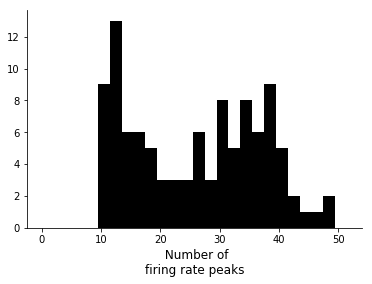

In [10]:
plot_distribution(allPeakIndexes,[-0.5,52,2],xyLabels=[" Number of\nfiring rate peaks",""])

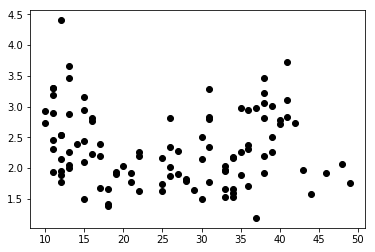

In [11]:
plt.plot(indexPeaks,zScoresAtPeak,'ko')

## Generate Figure Sup

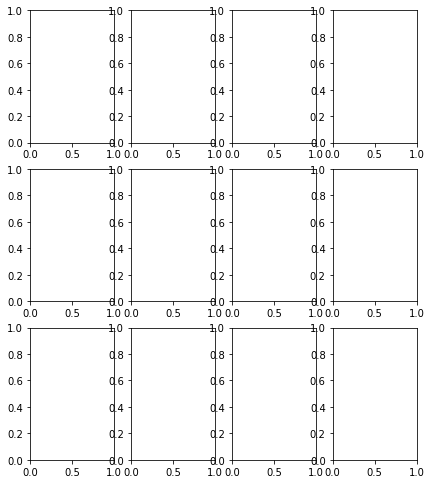

In [12]:
fig, ax = plt.subplots(figsize=(cm2inch(17.6),cm2inch(21)), ncols=4,nrows=3)

Preprocess behavior data loaded from /data/MOU025/Experiments/MOU025_2014_08_22_15_48/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU025/Experiments/MOU025_2014_08_22_15_48/Analysis/rawspikedata.p
Preprocess behavior data loaded from /data/MOU025/Experiments/MOU025_2014_08_29_12_54/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU025/Experiments/MOU025_2014_08_29_12_54/Analysis/rawspikedata.p
Preprocess behavior data loaded from /data/MOU025/Experiments/MOU025_2014_09_05_15_15/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU025/Experiments/MOU025_2014_09_05_15_15/Analysis/rawspikedata.p
Preprocess behavior data loaded from /data/MOU026/Experiments/MOU026_2014_09_01_18_06/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU026/Experiments/MOU026_2014_09_01_18_06/Analysis/rawspikedata.p
Preprocess behavior data loaded from /data/MOU027/Experiments/MOU027_2014_09_09_14_01/Analysis/preproces

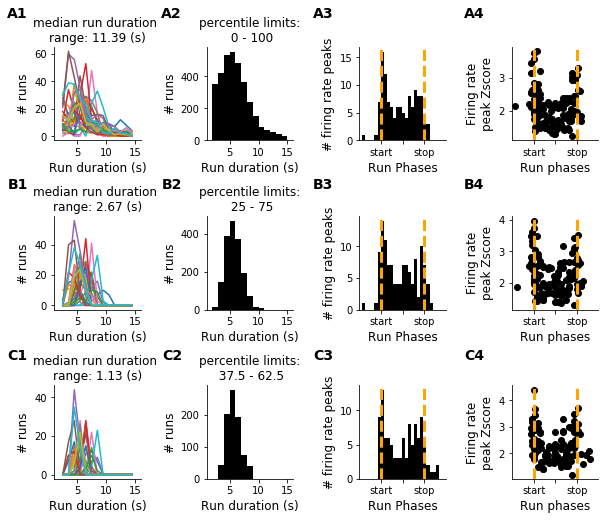

In [13]:
fig, ax = plt.subplots(figsize=(12*0.7, 8*0.9), ncols=4,nrows=3)

savePathData=os.path.join(root,"ALLMOU_Analysis")
behaviorType=["Runs","all"]
tagList = ["GoodPerfo"]
#specfiy run max 
minDuration=2
maxDuration=15
paramCarola=param

#list of all animals in data base:
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]


allRunRanges={}
percentileLimits=[[0,100],[25,75],[37.5, 62.5]]
for limitindex,percentileLimit in enumerate(percentileLimits):
    allRunRanges[limitindex]=[]
    #loop through aniaml animal
    runsDurationsAccrossSessions=[]
    runsDurationsInSessions=[]
    for animal in animalList:

        #Get the list of all sessions in one animal
        sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
        sessionList=sorted(sessionList)   

        #loop through sessions and check for presence of tag to analyse or not
        for index,session in enumerate(sessionList):
            #if tag list is not emtpy
            if tagList:
                #check if the session has the specficied tag
                if not has_tag(root, animal, session, tagList):
                    continue
            # get session data   
            data=Data(root,session[:6],session,paramCarola,redoPreprocess=False)


            runBegs,runEnds= np.asarray(detect_running_period(data, minDuration, maxDuration, runType='all')[0:2])
            runDurations=[]
            for runBeg,runEnd in zip(runBegs,runEnds):
                runDurations.extend([runEnd-runBeg])
            
            
            ### constrain run duration
            runLimitValues=np.percentile(runDurations,percentileLimit)
            allRunRanges[limitindex].append(runLimitValues)
            runDurations=[run for run in runDurations if (run>=runLimitValues[0]) & (run<=runLimitValues[1])]
            runsDurationsInSessions.append(runDurations)
            runsDurationsAccrossSessions.extend(runDurations)
      
    
     # FOR EACH CONSTRAINED CONDITION PLOT dISTRUBUTIONS
    
    
    #first plot distribition session by session
    maxminstep=[2,15,1]
    binCenters=np. arange(maxminstep[0]+maxminstep[2]/2,maxminstep[1]+maxminstep[2]/2,maxminstep[2])
    for runsDurationsInSession in runsDurationsInSessions:
        Nevent,Binedges=np.histogram(runsDurationsInSession,np.arange(maxminstep[0],maxminstep[1]+maxminstep[2],maxminstep[2]),density=False)
        ax[limitindex][0].plot(binCenters,Nevent)
    
    allRunRangesAfterConstrain=[]
    for run in allRunRanges[limitindex]:
        allRunRangesAfterConstrain.append(np.diff(run)[0])
    
    medianrange=np.median(allRunRangesAfterConstrain)
    stdrange=np.std(allRunRangesAfterConstrain)
    
    
    
    # plot the entire distribution 
    
    ax[limitindex][0].set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    ax[limitindex][0].set_xlabel("Run duration (s)",fontsize=12)
    ax[limitindex][0].set_ylabel("# runs",fontsize=12)
    ax[limitindex][0].spines['top'].set_color("none")
    ax[limitindex][0].spines['right'].set_color("none")
    ax[limitindex][0].yaxis.set_ticks_position('left')
    ax[limitindex][0].xaxis.set_ticks_position('bottom')
    ax[limitindex][0].get_xaxis().set_tick_params(direction='out')
    ax[limitindex][0].set_title('median run duration \nrange: %s (s)' %str(round(medianrange,2)))
    
    

    plot_distribution(runsDurationsAccrossSessions,[2,15,1],xyLabels=["Run duration (s)","# runs"],histType='bar',ax=ax[limitindex][1])   
    ax[limitindex][1].set_title('percentile limits:\n %s - %s' %(str(percentileLimit[0]),str(percentileLimit[1])))
    
    # load the result of modulation
    
    
    pickleBaseName ='AllPeakFRatesIndexes_RunDuration'+ str(round(percentileLimit[0],2)) + '-' + str(round(percentileLimit[1],2)) + '.p'
    pickleFullPathAndName=os.path.join(savePathData,pickleBaseName)
    allPeakIndexes=pickle.load(open(pickleFullPathAndName,"rb"))
    plot_distribution(allPeakIndexes,[-0.5,52,2],xyLabels=["Run Phases","# firing rate peaks"],ax=ax[limitindex][2])
    ax[limitindex][2].spines['top'].set_color("none")
    ax[limitindex][2].axvline(12,color="orange",linestyle='--',linewidth=3)
    ax[limitindex][2].axvline(40,color="orange",linestyle='--',linewidth=3)
    ax[limitindex][2].locator_params(axis='y',nbins=4)
    ax[limitindex][2].set_xticks([12,(12+40)/2,40])
    ax[limitindex][2].set_xticklabels(["start","","stop"])

    

    pickleBaseName ='AllPeakFRatesZscoreVersusIndexes_RunDuration'+ str(round(percentileLimit[0],2)) + '-' + str(round(percentileLimit[1],2)) + '.p'
    pickleFullPathAndName=os.path.join(savePathData,pickleBaseName)
    [indexPeaks,zScoresAtPeak]=pickle.load(open(pickleFullPathAndName,"rb"))
    ax[limitindex][3].plot(indexPeaks,zScoresAtPeak,'ko')
    ax[limitindex][3].set_ylabel("Firing rate\npeak Zscore",fontsize=12)
    ax[limitindex][3].set_xlabel("Run phases", fontsize=12)
    ax[limitindex][3].set_xlim([-2.5,54])
    ax[limitindex][3].spines['top'].set_color("none")
    ax[limitindex][3].spines['right'].set_color("none")
    ax[limitindex][3].yaxis.set_ticks_position('left')
    ax[limitindex][3].xaxis.set_ticks_position('bottom')
    ax[limitindex][3].axvline(12,color="orange",linestyle='--',linewidth=3)
    ax[limitindex][3].axvline(40,color="orange",linestyle='--',linewidth=3)
    ax[limitindex][3].locator_params(axis='y',nbins=4)
    ax[limitindex][3].get_xaxis().set_tick_params(direction='out')
    ax[limitindex][3].set_xticks([12,(12+40)/2,40])
    ax[limitindex][3].set_xticklabels(["start","","stop"])
    

plt.tight_layout()
figuresLabels={"A1":[0.035,0.97],"B1":[0.035,0.64],"C1":[0.035,0.31],"A2":[0.29,0.97],"B2":[0.29,0.64],"C2":[0.29,0.31],
               "A3":[0.54,0.97],"B3":[0.54,0.64],"C3":[0.54,0.31],"A4":[0.79,0.97],"B4":[0.79,0.64],"C4":[0.79,0.31]}
for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0],coordinates[1],label,figure=fig,weight='bold',fontsize=14,ha='right' ,va='bottom')
    
saveFullName=os.path.join(saveFigurePath,'RevisedFigS02_DifferentRunDurationRanges.pdf')
plt.savefig(saveFullName,orientation='landscape',dpi=600,format='pdf')

In [14]:
# stats

In [22]:
from scipy import stats
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))


In [15]:
from scipy import stats

def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

# allModulatedIndexesInRuns=[index for index in allModulatedIndex if (index>=12) & (index<=40) ]
# allModulatedIndexesInRunsNorm=normalize(allModulatedIndexesInRuns)
# len(allModulatedIndexesInRunsNorm)
# print(stats.kstest(allModulatedIndexesInRunsNorm,'uniform'))

allPeakIndexesInRuns=[index for index in allPeakIndexes if (index>=11) & (index<=41) ]

allPeakIndexesInRunsNorm=normalize(allPeakIndexesInRuns)
stats.kstest(allPeakIndexesInRunsNorm,'uniform')

KstestResult(statistic=0.14166666666666666, pvalue=0.03825562888096479)

In [16]:
for limitindex,percentileLimit in enumerate(percentileLimits):
    pickleBaseName ='AllPeakFRatesIndexes_RunDuration'+ str(round(percentileLimit[0],2)) + '-' + str(round(percentileLimit[1],2)) + '.p'
    pickleFullPathAndName=os.path.join(savePathData,pickleBaseName)
    allPeakIndexes=pickle.load(open(pickleFullPathAndName,"rb"))
    allPeakIndexesInRuns=[index for index in allPeakIndexes if (index>=11) & (index<=43) ]
    allPeakIndexesInRunsNorm=normalize(allPeakIndexesInRuns)
    print(stats.kstest(allPeakIndexesInRunsNorm,'uniform'))

KstestResult(statistic=0.1595394736842105, pvalue=0.005305519872317532)
KstestResult(statistic=0.17410714285714285, pvalue=0.001936484077045053)
KstestResult(statistic=0.14158163265306123, pvalue=0.03546190400740934)
